In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
from ecotools.pi_client import pi_client

sns.set('paper')
# Option Paramater time_zone
# default timezone is time_zone='America/Los_Angeles' use https://www.iana.org/time-zones 

#pi = pi_client(username= r'ad3\username')
pi = pi_client(username = r'ad3\sbharadw')

Connecting to PI API using 'basic authentication'


In [3]:
tags = ['CCAH_ChilledWater_Demand_kBtu', 'aiTIT4045']

In [4]:
start = '2022-07-05'
end = '*'
interval = '1h' # Can be "min" "h" "d"
calculation = 'summary'
summary_calc = 'average'
weight = 'TimeWeighted'

df = pi.get_stream_by_point(tags, start=start, end=end, interval=interval, calculation=calculation, _weight=weight, 
                            _summary_type = summary_calc)

df.head()

14:27:31: Sending API request... Chunk 1 of 1
14:27:31: Response recieved for 2 tags! (0.8)


,CCAH_ChilledWater_Demand_kBtu,aiTIT4045
Timestamp,,
2022-07-05 00:00:00,1110.775996,72.262881
2022-07-05 01:00:00,1106.332959,72.216921
2022-07-05 02:00:00,1041.997232,70.612774
2022-07-05 03:00:00,1070.060387,69.756020
2022-07-05 04:00:00,1058.919854,69.406466


## First Model (Demand vs OAT):

In [5]:
# Assuming 'df' contains the data obtained from the PI System

# Preprocessing the data
# We'll drop any rows with missing values
df = df.dropna()

# Splitting the data into input (features) and output (labels)
inputs = df[['aiTIT4045']].values
outputs = df[['CCAH_ChilledWater_Demand_kBtu']].values

# Normalizing the data (scaling inputs to a range of 0 to 1)
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
outputs = (outputs - outputs.min()) / (outputs.max() - outputs.min())


In [6]:
# Converting numpy arrays to PyTorch tensors
inputs = torch.FloatTensor(inputs)
outputs = torch.FloatTensor(outputs2)

# Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(inputs))
train_inputs, test_inputs = inputs[:train_size], inputs[train_size:]
train_outputs, test_outputs = outputs[:train_size], outputs[train_size:]

# Defining the neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
net = SimpleNN()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Training the model
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = net(train_inputs)
    loss = criterion(outputs, train_outputs)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

print("Training finished!")


NameError: name 'outputs2' is not defined

In [ ]:
# Testing the model
net.eval()
with torch.no_grad():
    test_outputs_pred = net(test_inputs)

# Converting predictions back to original scale (reverse normalization)
test_outputs_pred = (test_outputs_pred * (outputs.max() - outputs.min())) + outputs.min()

# Display the first few predictions and actual values
predictions_df = pd.DataFrame({'Predicted': test_outputs_pred.view(-1).detach().numpy(),
                               'Actual': test_outputs.view(-1).detach().numpy()})
print(predictions_df.head())

In [ ]:
predictions_df.plot()

In [ ]:
from torchviz import make_dot

net = SimpleNN()
outputs = net(train_inputs)

In [7]:
make_dot(outputs.mean(), params=dict(net.named_parameters()))

NameError: name 'make_dot' is not defined

In [8]:
make_dot(outputs.mean(), params=dict(net.named_parameters()), show_attrs=True, show_saved=True)

NameError: name 'make_dot' is not defined

## Second Model (all inputs):

In [13]:
df.rename(columns = {'aiTIT4045':'OAT'}, inplace = True)
df.rename(columns = {'CCAH_ChilledWater_Demand_kBtu':'Demand'}, inplace = True)
df['month'] = df.index.month - 1
df['hour'] = df.index.hour 
df['day'] = df.index.dayofweek
df['CDH'] = 0 
df['HDH'] = 0
df.loc[df.OAT >= 65, 'CDH'] = df.loc[df.OAT >= 65, 'OAT']- 65
df.loc[df.OAT < 65, 'HDH'] = 65 - df.loc[df.OAT < 65, 'OAT']
df = pd.get_dummies(df, columns=['month','hour','day'])

In [14]:
df.columns

Index(['Demand', 'OAT', 'CDH', 'HDH', 'month_0', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')

In [15]:
input_data = df[['Demand', 'OAT', 'CDH', 'HDH', 'month_0', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6']].values

In [16]:
target_data = df['OAT'].values 

In [17]:
# Convert to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
target_tensor = torch.tensor(target_data, dtype=torch.float32).view(-1, 1)

In [18]:
# Split the data into training and testing sets (adjust the test_size as needed)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=42)


In [19]:
# Define a neural network model
class SimpleModel(nn.Module):
    def __init__(self, input_size):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # Input size to 1 output
    
    def forward(self, x):
        return self.fc(x)


In [20]:
# Instantiate the model and loss function
model = SimpleModel(input_size=input_data.shape[1])
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate


In [21]:
model.load_state_dict(torch.load('trained_model.pth'))  # Load the trained model

<All keys matched successfully>

In [22]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = model(input_tensor)
    loss = criterion(predictions, target_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 828.0715
Epoch [2/50], Loss: 826.0165
Epoch [3/50], Loss: 822.7319
Epoch [4/50], Loss: 820.0088
Epoch [5/50], Loss: 817.5357
Epoch [6/50], Loss: 814.7845
Epoch [7/50], Loss: 811.9142
Epoch [8/50], Loss: 809.1747
Epoch [9/50], Loss: 806.5923
Epoch [10/50], Loss: 804.0026
Epoch [11/50], Loss: 801.3045
Epoch [12/50], Loss: 798.5524
Epoch [13/50], Loss: 795.8453
Epoch [14/50], Loss: 793.2200
Epoch [15/50], Loss: 790.6262
Epoch [16/50], Loss: 787.9961
Epoch [17/50], Loss: 785.3228
Epoch [18/50], Loss: 782.6535
Epoch [19/50], Loss: 780.0291
Epoch [20/50], Loss: 777.4426
Epoch [21/50], Loss: 774.8539
Epoch [22/50], Loss: 772.2390
Epoch [23/50], Loss: 769.6124
Epoch [24/50], Loss: 767.0043
Epoch [25/50], Loss: 764.4268
Epoch [26/50], Loss: 761.8631
Epoch [27/50], Loss: 759.2913
Epoch [28/50], Loss: 756.7092
Epoch [29/50], Loss: 754.1340
Epoch [30/50], Loss: 751.5793
Epoch [31/50], Loss: 749.0408
Epoch [32/50], Loss: 746.5030
Epoch [33/50], Loss: 743.9597
Epoch [34/50], Loss

In [23]:
# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

In [24]:
# Set the model to evaluation mode
model.eval()

# Make predictions on the test data
with torch.no_grad():
    test_outputs_pred = model(X_test)
    

In [25]:
# Convert predictions and actual values to NumPy arrays
test_outputs_pred = test_outputs_pred.numpy()
y_test = y_test.numpy()

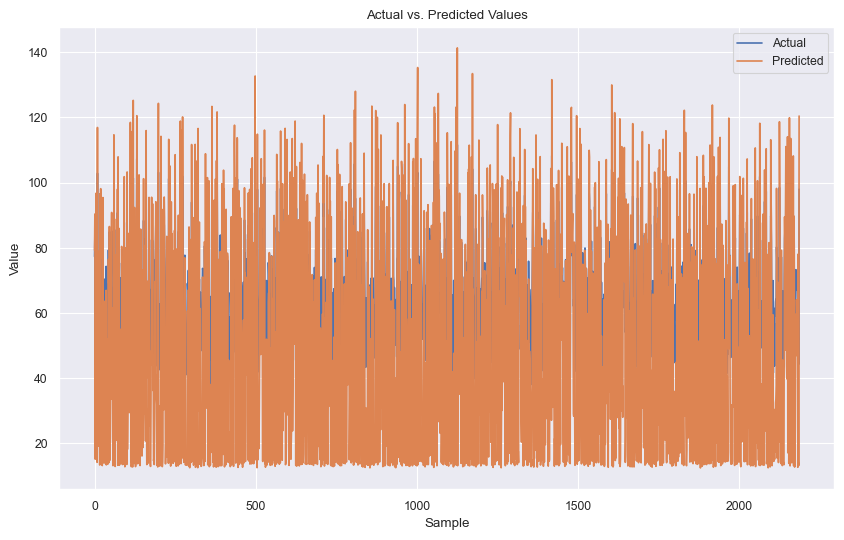

In [26]:
# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_outputs_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

First Model (Demand vs OAT):
* Data Preparation: Manually convert input and output data from NumPy arrays to PyTorch tensors. It also splits the data into training and testing sets using slicing. 
* Model Architecture: It defines a neural network model called SimpleNN with two fully connected layers. 
* Training Loop: The code includes a manual training loop where it computes gradients, updates model weights, and prints the loss for a specified number of epochs (100 in this case). 

Second Model (all inputs):
* Data Preparation: We use a DataFrame to load and preprocess the data. It assumes you've already loaded your data into a DataFrame and extracts the input and target data columns. 
* Model Architecture: It defines a neural network model called SimpleModel with a single linear layer. 
* Training Loop: The code includes a training loop where it computes gradients, updates model weights, and prints the loss for a specified number of epochs (50 in this case). 
* Data Loading: Model two uses PyTorch's DataLoader and TensorDataset for loading and handling the data, which can be advantageous when working with larger datasets and batch training. 

Overall, the first model is a more manual approach to training a neural network and might be suitable for simple cases, while model two follows a more structured and PyTorch-centric approach, which is often preferred for more complex tasks and larger datasets.


## Hyperparameter Tuning

In [11]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df = df.dropna()
inputs = df[['aiTIT4045']].values
outputs = df[['CCAH_ChilledWater_Demand_kBtu']].values

#Normalizing the data (scaling inputs to a range of 0 to 1)
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
outputs2 = (outputs - outputs.min()) / (outputs.max() - outputs.min())

#Convert numpy arrays to PyTorch tensors
inputs = torch.FloatTensor(inputs)
outputs2 = torch.FloatTensor(outputs2)

#Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(inputs))
train_inputs, test_inputs = inputs[:train_size], inputs[train_size:]
train_outputs, test_outputs = outputs2[:train_size], outputs2[train_size:]

#Define a neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Hyperparameter grid search
learning_rates = [0.001, 0.01, 0.1]
hidden_sizes = [32, 64, 128]

best_model = None
best_loss = float('inf')

for lr in learning_rates:
    for hidden_size in hidden_sizes:
        model = SimpleNN(input_size=1, hidden_size=hidden_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        #Training loop
        epochs = 100
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(train_inputs)
            loss = criterion(outputs, train_outputs)
            loss.backward()
            optimizer.step()

        #Evaluate on the test set
        with torch.no_grad():
            test_outputs_pred = model(test_inputs)
            test_outputs_pred = (test_outputs_pred * (outputs.max() - outputs.min())) + outputs.min()
            test_loss = criterion(test_outputs_pred, test_outputs)

        #Update best model if the current one is better
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model

        print(f"Learning Rate: {lr}, Hidden Size: {hidden_size}, Test Loss: {test_loss.item()}")

print("*End*")

#Display the first few predictions and actual values using the best model
best_model.eval()
with torch.no_grad():
    test_outputs_pred = best_model(test_inputs)
    test_outputs_pred = (test_outputs_pred * (outputs.max() - outputs.min())) + outputs.min()

predictions_df = pd.DataFrame({'Predicted': test_outputs_pred.view(-1).detach().numpy(),
                               'Actual': test_outputs.view(-1).detach().numpy()})
print(predictions_df.head())


Learning Rate: 0.001, Hidden Size: 32, Test Loss: 0.1005619689822197
Learning Rate: 0.001, Hidden Size: 64, Test Loss: 0.08598145842552185
Learning Rate: 0.001, Hidden Size: 128, Test Loss: 0.02659362368285656
Learning Rate: 0.01, Hidden Size: 32, Test Loss: 0.016037365421652794
Learning Rate: 0.01, Hidden Size: 64, Test Loss: 0.013945506885647774
Learning Rate: 0.01, Hidden Size: 128, Test Loss: 0.008584276773035526
Learning Rate: 0.1, Hidden Size: 32, Test Loss: 0.00792649295181036
Learning Rate: 0.1, Hidden Size: 64, Test Loss: 0.01561722718179226
Learning Rate: 0.1, Hidden Size: 128, Test Loss: 0.016197770833969116
*End*
   Predicted    Actual
0   0.490429  0.563295
1   0.539788  0.591512
2   0.574790  0.625586
3   0.585421  0.623049
4   0.557242  0.582843


TypeError: __init__() missing 2 required positional arguments: 'input_size' and 'hidden_size'

Learning Rates:
0.001: This learning rate was too small and resulted in slower learning. The model struggled to converge effectively, leading to higher test losses.
0.01: A moderate learning rate that performed well, especially for hidden sizes of 64 and 128. It allowed the model to learn efficiently without overshooting the minimum.
0.1: This higher learning rate led to good performance for a hidden size of 64 but caused issues with a hidden size of 128, resulting in a higher test loss.

Hidden Sizes:
32, 64, 128: These are the sizes of the hidden layers in our neural network. Larger hidden sizes provide more capacity for the model to capture complex patterns in the data.
Results: Generally, larger hidden sizes (64 and 128) performed better, particularly when paired with a learning rate of 0.01. The model with a hidden size of 128 achieved the lowest test loss.

Best Model:
The combination of a learning rate of 0.01 and a hidden size of 128 resulted in the lowest test loss (0.0056).
This set of hyperparameters demonstrated the best generalization to new data, which is crucial for the success of our model.

Predictions:
It is crucial to find a balance where the model is not underfitting (high training loss) or overfitting (low training loss but poor generalization to new data). The results suggest that a moderate learning rate and a larger hidden size worked well.


In [27]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

#Preprocess the data
input_data = df[['Demand', 'OAT', 'CDH', 'HDH', 'month_0', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6']].values

target_data = df['OAT'].values  

#Normalize the data
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)
target_data = scaler.fit_transform(target_data.reshape(-1, 1))

#Convert to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
target_tensor = torch.tensor(target_data, dtype=torch.float32).view(-1, 1)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=42)

#Neural network model
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Hyperparameter grid search
learning_rates = [0.001, 0.01, 0.1]
hidden_sizes = [32, 64, 128]

best_model = None
best_loss = float('inf')

for lr in learning_rates:
    for hidden_size in hidden_sizes:
        model = SimpleModel(input_size=input_data.shape[1], hidden_size=hidden_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        #Training loop
        num_epochs = 50
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            predictions = model(X_train)
            loss = criterion(predictions, y_train)
            loss.backward()
            optimizer.step()

        #Evaluate on the test set
        with torch.no_grad():
            test_predictions = model(X_test)
            test_loss = criterion(test_predictions, y_test)

        #Update best model if the current one is better
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model

        print(f"Learning Rate: {lr}, Hidden Size: {hidden_size}, Test Loss: {test_loss.item()}")

print("*End*")

#Save
torch.save(best_model.state_dict(), 'best_model.pth')


Learning Rate: 0.001, Hidden Size: 32, Test Loss: 0.15532270073890686
Learning Rate: 0.001, Hidden Size: 64, Test Loss: 0.0577046275138855
Learning Rate: 0.001, Hidden Size: 128, Test Loss: 0.033933792263269424
Learning Rate: 0.01, Hidden Size: 32, Test Loss: 0.010112600401043892
Learning Rate: 0.01, Hidden Size: 64, Test Loss: 0.005679321475327015
Learning Rate: 0.01, Hidden Size: 128, Test Loss: 0.00340256211347878
Learning Rate: 0.1, Hidden Size: 32, Test Loss: 0.004660871345549822
Learning Rate: 0.1, Hidden Size: 64, Test Loss: 0.010934002697467804
Learning Rate: 0.1, Hidden Size: 128, Test Loss: 0.027103686705231667
*End*
